# E10: Experimental data from a turbulent boundary layer
We use experimental data from a zero-pressure gradient turbulent boundary layer from the high Reynolds number wind tunnel at the University of Melbourne. The friction Reynolds number is $Re_{\tau} = u_\tau
\delta / \nu = 14,750$, based on the thickness of the boundary layer
$\delta$, the kinematic viscosity $\nu$, and the average friction
velocity at the wall $u_\tau$. The time signals consists of the
streamwise velocity at two wall-normal locations within the inner
(I) and outer (O) layers, denoted by $u_I(t)$ and $u_O(t)$,
respectively. Here, we leverage SURD
  to investigate the interaction between flow velocity motions in the
  outer layer (far from the wall) and inner layer (close to the wall)
  of a turbulent boundary layer. More specifically, the
  hypotheses under consideration are either i) a dominant influence of
  motions far from the wall on those closer, indicating top-down
  causality (a.k.a. Townsend's outer-layer similarity hypothesis), or ii) the opposite scenario, where influences
  move from areas closer to the wall outward, suggesting bottom-up
  causality.


In [16]:
import os, sys
sys.path.append(os.path.abspath('../utils'))
import numpy as np
import pymp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.io import loadmat
import pickle
import surd as surd
import it_tools as it
from tqdm import tqdm
np.random.seed(10)

# Configure matplotlib to use LaTeX for text rendering and set font size
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

colors = {}
colors['redundant'] = mcolors.to_rgb('#003049')
colors['unique'] = mcolors.to_rgb('#d62828')
colors['synergistic'] = mcolors.to_rgb('#f77f00')
for key, value in colors.items():
    rgb = mcolors.to_rgb(value)
    colors[key] = tuple([c + (1-c) * 0.15 for c in rgb])

## Problem set-up

In [17]:
# Load TBLparam.mat
tbl_param = loadmat('../data/inner_outer_tbl_param.mat')

# Extract necessary variables from TBLparam
z1 = tbl_param['z1']
z2 = tbl_param['z2']
utau = tbl_param['utau'].item()
nu = tbl_param['nu'].item()
delta = tbl_param['delta'].item()
fs = tbl_param['fs'].item()

# Calculate the wall-normal outer location normalized with plus units and the boundary layer thickness
z1plus = z1 * utau / nu
z1delta = z1 / delta

# Calculate the wall-normal inner location normalized with plus units and the boundary layer thickness
z2plus = z2 * utau / nu
z2delta = z2 / delta

# Print specific values for both inner and outer regions
print("Outer region:")
print(f"z1plus = {z1plus[31][0]}")
print(f"z1delta = {z1delta[31][0]}")

print("\nInner region:")
print(f"z2plus = {z2plus[0][0]}")
print(f"z2delta = {z2delta[0][0]}")

Outer region:
z1plus = 4632.316308785342
z1delta = 0.314040631581906

Inner region:
z2plus = 4.33
z2delta = 0.0002935455707484299


## Inner/outer layer signals

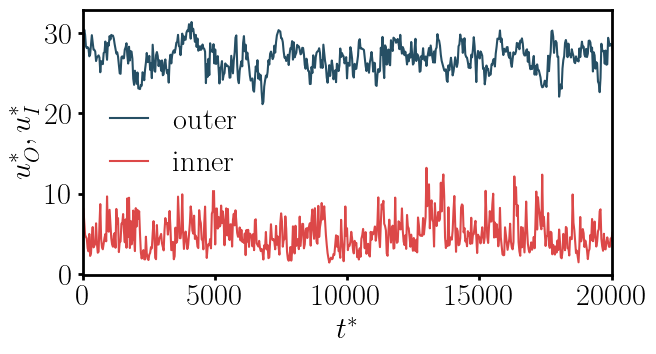

In [18]:
# Load the data
u_data = loadmat('../data/inner_outer_u_z32_c2.mat')
data = u_data['data']

# Set up parameters for plotting
lim = 20000
to = 10000

# Create the plot
fig, axs = plt.subplots(1, 1, figsize=(8, 4))
fs = tbl_param['fs'].item()  # Assuming 'fs' is still needed from the previous context

# Plot the outer and inner data
axs.plot(np.arange(lim)[::25] / fs * utau**2 / nu, 
         data[to:lim + to:25, 0] / utau, 
         label='$\\rm outer$', 
         color=colors['redundant'], 
         linewidth=1.5, 
         linestyle='-')

axs.plot(np.arange(lim)[::25] / fs * utau**2 / nu, 
         data[to:lim + to:25, 1] / utau, 
         label='$\\rm inner$', 
         color=colors['unique'], 
         linewidth=1.5, 
         linestyle='-')

# Set labels and legend
axs.set_ylabel('$u_O^*, u_I^*$')
axs.set_xlabel('$t^*$')

# Customize legend
leg = axs.legend(edgecolor='white', handlelength=1.25, loc='center left')
leg.get_frame().set_alpha(None)
leg.get_frame().set_facecolor((1, 1, 1, 1))

# Set limits and aspect ratio
axs.set_xlim(0, lim)
axs.set_box_aspect(1/2)

# Customize spines and ticks
for axis in ['top', 'bottom', 'left', 'right']:
    axs.spines[axis].set_linewidth(2)

axs.tick_params(width=2)

# Show the plot
plt.tight_layout()
plt.show()

## Selection of time-lag

This section aims at finding the optimal time lag for performing the causality analysis. It might take a while since it performs the causality analysis for different values of the time lag for all the variables. In this study, the selected time lag is the one that maximizes the unique causality without considering self-causality. You can also comment this section and use the value of the lag given in the following section.

100%|█████████| 3000/3000 [09:03<00:00,  5.52it/s]


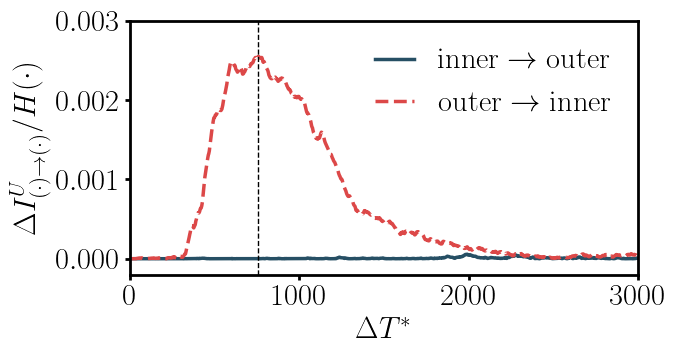

Maximum cross-induced causality occurs at lag index 593, or 756.20 plus units


In [19]:
# Prepare the data for causality analysis
X = data.T
X -= X.mean(axis=1, keepdims=True)
X /= X.std(axis=1, keepdims=True)

nvars = X.shape[0]
nbins = 10
nlags_range = range(1, 3001, 1)  # Define the range of lag values
cross_unique_lag = pymp.shared.array((nvars, len(nlags_range)), dtype=np.float64)  # Initialize a shared array

# Initialize progress bar for parallel computation
total_iterations = len(nlags_range)
progress_bar = tqdm(total=total_iterations, ncols=50)

# Parallel computation across variables
with pymp.Parallel(nvars) as par:
    for i in par.range(nvars):
        for nlag in nlags_range:
            # Prepare the data for causality analysis
            Y = np.vstack([X[i, nlag:], X[:, :-nlag]])
            hist, _ = np.histogramdd(Y.T, bins=nbins)
            I_R, I_S, MI, info_leak = surd.surd(hist)
            H = it.entropy_nvars(hist, (0,))

            # Sum causalities for single-digit tuples
            single_digit_keys = [key for key in I_R.keys() if len(key) == 1 and key != (i + 1,)]
            sum_causalities = sum(I_R[key] for key in single_digit_keys)

            # Store the sum for this variable and nlag
            cross_unique_lag[i, nlag - np.min(nlags_range)] = sum_causalities / H

            # Update progress bar
            progress_bar.update(1)

# Plotting the results
progress_bar.close()
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

# Plot for inner to outer and outer to inner
axs.plot(np.arange(nlags_range[-1]) / fs * utau**2 / nu, 
         cross_unique_lag[0, :], 
         color=colors['redundant'],
         linewidth=2.5, 
         linestyle='-', 
         label='$\\rm inner \\rightarrow outer$')

axs.plot(np.arange(nlags_range[-1]) / fs * utau**2 / nu, 
         cross_unique_lag[1, :], 
         color=colors['unique'], 
         linewidth=2.5, 
         linestyle='-', 
         label='$\\rm outer \\rightarrow inner$')

# Customize legend
leg = axs.legend(loc='upper right', edgecolor='white', handlelength=1.25)
leg.get_frame().set_alpha(None)
leg.get_frame().set_facecolor((1, 1, 1, 1))

# Customize labels and limits
axs.set_ylabel(f'$\\Delta I_{{(\\cdot)\\rightarrow (\\cdot)}}^U / H(\\cdot)$')
axs.set_xlabel(f'$\\Delta T^*$')
axs.set_xlim(0, 3000)
axs.set_ylim(bottom=-0.0002, top=0.003)

# Add vertical line at max causality for outer to inner
max_lag = cross_unique_lag[1, :].argmax()
max_lag_time = (max_lag - 1) / fs * utau**2 / nu
axs.axvline(max_lag_time, linewidth=1, linestyle='--', color='black')

# Customize plot appearance
axs.set_box_aspect(1 / 2)
for axis in ['top', 'bottom', 'left', 'right']:
    axs.spines[axis].set_linewidth(2)
axs.tick_params(width=2)

# Save and show plot
plt.tight_layout()
plt.show()

# Print the max lag with formatting
print(f"Maximum cross-induced causality occurs at lag index {max_lag}, "
      f"or {max_lag_time:.2f} plus units")


## Causality analysis

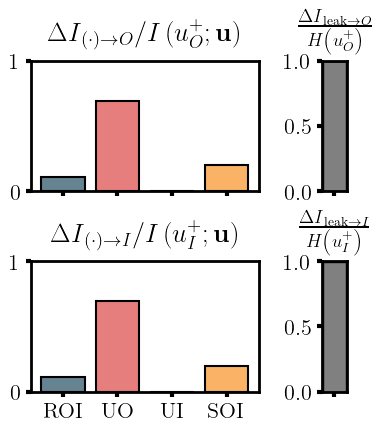

In [20]:
plt.rcParams.update({'font.size': 16})

# Load data for c1, c2, and c3
u_data_c1 = loadmat('../data/inner_outer_u_z32_c1.mat')
u_data_c2 = loadmat('../data/inner_outer_u_z32_c2.mat')
u_data_c3 = loadmat('../data/inner_outer_u_z32_c3.mat')

# Extract data
data_c1 = u_data_c1['data'].T
data_c2 = u_data_c2['data'].T
data_c3 = u_data_c3['data'].T

# Initialize variables
nbins = 10
nlag = cross_unique_lag[1, :].argmax() if 'cross_unique_lag' in globals() else 593
nvars = data_c1.shape[0]  # Number of variables

# Prepare subplots
fig, axs = plt.subplots(nvars, 2, figsize=(7, 2.3 * nvars), gridspec_kw={'width_ratios': [35, 1]})

# Initialize storage for average calculations
I_R_avg = {}
I_S_avg = {}
info_leak_avg = 0

# Process each cycle and compute results
for cycle, data in enumerate([data_c1, data_c2, data_c3]):
    for i in range(nvars):
        # Organize data (0 target variable, 1: agent variables)
        Y = np.vstack([data[i, nlag:], data[:, :-nlag]])
        
        # Run SURD
        hist, _ = np.histogramdd(Y.T, nbins)
        I_R, I_S, MI, info_leak = surd.surd(hist)
        
        # Print results
        # surd.nice_print(I_R, I_S, MI, info_leak)
        
        # Accumulate results
        for key in I_R:
            if key in I_R_avg:
                I_R_avg[key] += I_R[key]
            else:
                I_R_avg[key] = I_R[key]
        
        for key in I_S:
            if key in I_S_avg:
                I_S_avg[key] += I_S[key]
            else:
                I_S_avg[key] = I_S[key]
        
        info_leak_avg += info_leak

# Average results
I_R_avg = {key: value / 3 for key, value in I_R_avg.items()}
I_S_avg = {key: value / 3 for key, value in I_S_avg.items()}
info_leak_avg /= 3

information_flux = {}
for i in range(nvars):
    # Plot SURD
    information_flux[i+1] = surd.plot(I_R_avg, I_S_avg, info_leak, axs[i,:], nvars, threshold=-0.01)
    
    # Plot formatting
    axs[i,0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow {i+1}}} / I \\left(Q_{i+1}^+ ; \\mathrm{{\\mathbf{{Q}}}} \\right)$', pad=11)
    axs[i,1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow {i+1}}}}}{{H \\left(Q_{i+1} \\right)}}$', pad=20)
    axs[i,0].set_xticklabels(axs[i,0].get_xticklabels(), fontsize=20, rotation = 60, ha = 'right', rotation_mode='anchor')
    axs[i, 0].set_ylim([0,1])
    axs[i, 0].set_box_aspect(1/1.75)

    # Show the results
    for j in range(0,nvars-1):
        axs[j,0].set_xticklabels('')

axs[0, 0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow O}} / I \\left(u_O^+ ; \\mathrm{{\\mathbf{{u}}}} \\right)$', pad=15)
axs[0, 1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow O}}}}{{H \\left(u_O^+\\right)}}$', pad=20)
axs[1, 0].set_title(f'${{\\Delta I}}_{{(\\cdot) \\rightarrow I}} / I \\left(u_I^+ ; \\mathrm{{\\mathbf{{u}}}} \\right)$', pad=15)
axs[1, 1].set_title(f'$\\frac{{{{\\Delta I}}_{{\\mathrm{{leak}} \\rightarrow I}}}}{{H \\left(u_I^+\\right)}}$', pad=20)
axs[1, 0].set_xticklabels([f'$\\rm ROI$', f'$\\rm UO$', f'$\\rm UI$', f'$\\rm SOI$'], fontsize=16, rotation=0, ha='center', rotation_mode='anchor')

plt.tight_layout(w_pad=-9.5, h_pad=0.3)
# fig.savefig(os.path.join('figures', 'inner_outer_surd.pdf'), bbox_inches='tight')
plt.show()

The primary observation
  is that the inner layer motions are predominantly influenced by the
  unique causality from the outer layer, $\Delta I^U_{O \rightarrow
    I}$. The redundant and synergistic causalities are lower, but they
  remain significant. Curiously, the unique causality $\Delta I^U_{I
    \rightarrow I}$ is zero, implying that, at the time scale
  considered, the inner layer motions are independent of their past
  history. For the outer-layer motions, most of the causality is
  self-induced $\Delta I^U_{O \rightarrow O}$ with no apparent
  influence from the inner layer. The results distinctly support the
  prevalence of top-down interactions: causality flows predominantly
  from the outer-layer large-scale motions to the inner-layer
  small-scale motions.